# Library Packages

In [41]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/Users/facundosolano/opt/anaconda3/envs/itba/lib/python3.10/site-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [42]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import initializers

# Load Normalized Data

This data have been cleaned, and normalized with
* LabelEncoders - for categorical variables
* StandardScaler - for continuous variables

In [253]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')
df.drop('index',axis='columns',inplace=True)

Columns in each dataset

In [254]:
set(df.columns.tolist())-set(df_test.columns.tolist())

{'Customers', 'Sales', 'level_0'}

# Data Analysis
Check some correlations between columns that will give us information about how to build the NN

In [255]:
df.columns

Index(['level_0', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week',
       'Day', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitat

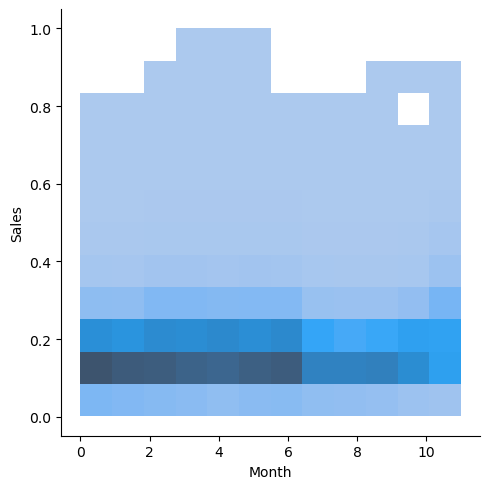

In [256]:
sns.displot(y=df.Sales,x=df.Month,bins=12)

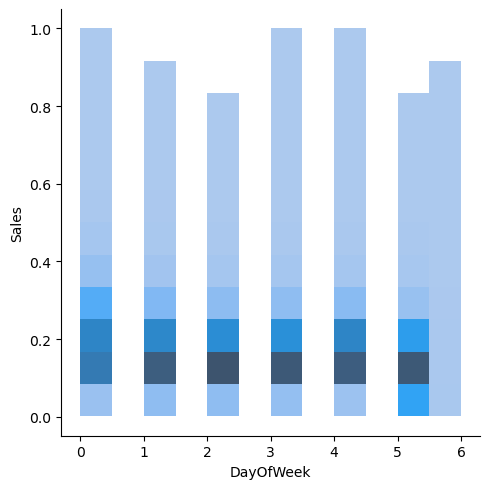

In [257]:
sns.displot(y=df.Sales,x=df.DayOfWeek,bins=12)

In [284]:
corr_df = df.corr().loc['Sales'].apply(lambda x: np.abs(x))
# corr_df = corr_df[corr_df > 0.5
# corr_df
corr_df[corr_df>0.1]

/var/folders/90/b05_bk0d2_z7wq_0d3_jqzd40000gn/T/ipykernel_80910/1491233022.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr().loc['Sales'].apply(lambda x: np.abs(x))


DayOfWeek               0.178753
Sales                   1.000000
Customers               0.823552
Promo                   0.368199
Assortment              0.109015
Promo2                  0.127556
Promo2SinceYear         0.119537
PromoInterval           0.120710
Promo2Days              0.132413
AfterPromo              0.183822
BeforePromo             0.280666
StateHoliday_bool_fw    0.110463
Promo_fw                0.190073
Name: Sales, dtype: float64

In [259]:
DataFrameSummary(df).summary().loc[['uniques', 'types', 'missing']]

/var/folders/90/b05_bk0d2_z7wq_0d3_jqzd40000gn/T/ipykernel_80910/1216867301.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  DataFrameSummary(df).summary().loc[['uniques', 'types', 'missing']]


,level_0,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
uniques,844338,1115,7,942,21733,4083,1,2,4,2,...,136,147,21,17,8,3,6,8,3,6
types,numeric,numeric,numeric,date,numeric,numeric,constant,bool,numeric,bool,...,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric
missing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [260]:
DataFrameSummary(df).summary().loc[['uniques', 'types', 'missing']].T.groupby('types').max()

/var/folders/90/b05_bk0d2_z7wq_0d3_jqzd40000gn/T/ipykernel_80910/190154049.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  DataFrameSummary(df).summary().loc[['uniques', 'types', 'missing']].T.groupby('types').max()


,uniques,missing
types,,
bool,2,0
categorical,135,0
constant,1,0
date,942,0
numeric,844338,0
unique,0,844338


# Data Model

In [285]:
# Embeddings dimensionality
cat_var_dict = {'Store': 50, 'DayOfWeek': 6, 'Year': 2, 'Month': 6,
    'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
    'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
    'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
    'Week': 2, 'Events': 4, 'Promo_fw': 1,
    'Promo_bw': 1, 'SchoolHoliday_fw': 1,
    'SchoolHoliday_bw': 1}

In [286]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']

In [287]:
# Check all columns on df are consistent with name of variables
set(contin_vars+list(cat_var_dict.keys()))-set(df.columns)

set()

### Create Embeddings Layers

In [288]:
# Recalculate dimensionality
for key in cat_var_dict.keys():
    dim = len(pd.unique(df[key]))
    emb_dim = (dim+2)//3
    cat_var_dict[key] = 50 if emb_dim>50 else emb_dim

In [289]:
def get_emb(feat):
    name = feat[0]
    c = len(pd.unique(df[name]))
    c2 = cat_var_dict[name]
    inp = Input((1,), dtype='int64', name=name+'_in')
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1)(inp))
    # print("name: ",name," dim: ",c," emd_dim: ",c2)
    return inp,u

In [290]:
# Analyze to use similar initializer
# def emb_init(shape, name=None):
#     return initializers.uniform(shape, scale=0.6/shape[1], name=name)

In [291]:
# for feat in df[contin_vars].items():
#     print(feat[0])
# for feat in df[list(cat_var_dict.keys())].items():
#     print(feat[0])

In [292]:
def get_contin(feat):
    name = feat[0]
    inp = Input((1,), name=name+'_in')
    return inp, Dense(1, name=name+'_d')(inp)

In [293]:
def get_contin_one():
    n_contin = df[contin_vars].shape[1]
    contin_inp = Input((n_contin,), name='contin')
    contin_out = BatchNormalization()(df[contin_vars])
    return contin_inp, contin_out

In [300]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/(y_true))))

In [294]:
split_contins = True

def get_model():
    if split_contins:
        conts = [get_contin(feat) for feat in df[contin_vars].items()]
        cont_out = [d for inp,d in conts]
        cont_inp = [inp for inp,d in conts]
    else:
        contin_inp, contin_out = get_contin_one()
        cont_out = [contin_out]
        cont_inp = [contin_inp]

    embs = [get_emb(feat) for feat in df[list(cat_var_dict.keys())].items()]
    x = Concatenate(name='All_Concatenate')([emb for inp,emb in embs] + cont_out)

    x = Dropout(0.02)(x)
    x = Dense(1000, activation='relu')(x)
    x = Dense(500, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model([inp for inp,emb in embs] + cont_inp, x)
    
    model.compile('adam', 'mean_absolute_error')
    model.compile(optimizer=Adam(learning_rate=0.001), metrics=['mse', rmspe], loss='mse')
    # model.compile(Adam(), 'mse')
    return model

In [295]:
def train(model, map_train, map_valid,  bs=128, ne=10):

    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

    return model.fit(map_train, y_trn, batch_size=bs, epochs=ne, verbose=1, validation_data=(map_valid, y_val), callbacks=[checkpoint])

### Train Model and Split Data

In [296]:
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

In [297]:
def split_data():
    if split_contins:
        map_train = split_cols(cats_trn) + split_cols(contins_trn)
        map_valid = split_cols(cats_val) + split_cols(contins_val)
    else:
        map_train = split_cols(cats_trn) + [contins_trn]
        map_valid = split_cols(cats_val) + [contins_val]
    return (map_train, map_valid)

In [298]:
n=len(df.Sales)

train_ratio=0.9
train_size = int(n*train_ratio)
contins_trn, contins_val = df[contin_vars].loc[:train_size-1], df[contin_vars].loc[train_size:]
cats_trn, cats_val       = df[cat_var_dict.keys()].loc[:train_size-1], df[cat_var_dict.keys()].loc[train_size:]
y_trn, y_val             = df.Sales[:train_size], df.Sales[train_size:]
# display(contins_trn, contins_val,cats_trn, cats_val,y_trn, y_val)

In [299]:
map_train, map_valid = split_data()

model = get_model()
# display(model.summary())
hist = np.array(train(model, map_train, map_valid, 128, 10).history['val_loss'])
print(hist)
print(hist.min())

name:  Store  dim:  1115  emd_dim:  50
name:  DayOfWeek  dim:  7  emd_dim:  3
name:  Year  dim:  3  emd_dim:  1
name:  Month  dim:  12  emd_dim:  4
name:  Day  dim:  31  emd_dim:  11
name:  StateHoliday  dim:  4  emd_dim:  2
name:  CompetitionMonthsOpen  dim:  25  emd_dim:  9
name:  Promo2Weeks  dim:  26  emd_dim:  9
name:  StoreType  dim:  4  emd_dim:  2
name:  Assortment  dim:  3  emd_dim:  1
name:  PromoInterval  dim:  4  emd_dim:  2
name:  CompetitionOpenSinceYear  dim:  21  emd_dim:  7
name:  Promo2SinceYear  dim:  8  emd_dim:  3
name:  State  dim:  12  emd_dim:  4
name:  Week  dim:  52  emd_dim:  18
name:  Events  dim:  22  emd_dim:  8
name:  Promo_fw  dim:  6  emd_dim:  2
name:  Promo_bw  dim:  6  emd_dim:  2
name:  SchoolHoliday_fw  dim:  8  emd_dim:  3
name:  SchoolHoliday_bw  dim:  8  emd_dim:  3
Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     

None

Epoch 1/10
5934/5937 [============================>.] - ETA: 0s - loss: 0.0166
Epoch 1: val_loss improved from inf to 0.01807, saving model to bestmodel.hdf5
5937/5937 [==============================] - 86s 14ms/step - loss: 0.0166 - val_loss: 0.0181
Epoch 2/10
5934/5937 [============================>.] - ETA: 0s - loss: 0.0123
Epoch 2: val_loss improved from 0.01807 to 0.01784, saving model to bestmodel.hdf5
5937/5937 [==============================] - 82s 14ms/step - loss: 0.0123 - val_loss: 0.0178
Epoch 3/10
5937/5937 [==============================] - ETA: 0s - loss: 0.0114
Epoch 3: val_loss did not improve from 0.01784
5937/5937 [==============================] - 83s 14ms/step - loss: 0.0114 - val_loss: 0.0183
Epoch 4/10
5937/5937 [==============================] - ETA: 0s - loss: 0.0109
Epoch 4: val_loss improved from 0.01784 to 0.01766, saving model to bestmodel.hdf5
5937/5937 [==============================] - 87s 15ms/step - loss: 0.0109 - val_loss: 0.0177
Epoch 5/10
5935/5937

In [276]:
[(name.columns,name.shape) for name in map_train]

[(Index(['Store'], dtype='object'), (759904, 1)),
 (Index(['DayOfWeek'], dtype='object'), (759904, 1)),
 (Index(['Year'], dtype='object'), (759904, 1)),
 (Index(['Month'], dtype='object'), (759904, 1)),
 (Index(['Day'], dtype='object'), (759904, 1)),
 (Index(['StateHoliday'], dtype='object'), (759904, 1)),
 (Index(['CompetitionMonthsOpen'], dtype='object'), (759904, 1)),
 (Index(['Promo2Weeks'], dtype='object'), (759904, 1)),
 (Index(['StoreType'], dtype='object'), (759904, 1)),
 (Index(['Assortment'], dtype='object'), (759904, 1)),
 (Index(['PromoInterval'], dtype='object'), (759904, 1)),
 (Index(['CompetitionOpenSinceYear'], dtype='object'), (759904, 1)),
 (Index(['Promo2SinceYear'], dtype='object'), (759904, 1)),
 (Index(['State'], dtype='object'), (759904, 1)),
 (Index(['Week'], dtype='object'), (759904, 1)),
 (Index(['Events'], dtype='object'), (759904, 1)),
 (Index(['Promo_fw'], dtype='object'), (759904, 1)),
 (Index(['Promo_bw'], dtype='object'), (759904, 1)),
 (Index(['SchoolHo

# Submit Competition

In [302]:
model.load_weights('bestmodel.hdf5')

In [305]:
y_pred = model.predict(map_valid, verbose=1)[:,0]#*y_max
y_pred_test = model.predict(df_test, verbose=1)[:,0]#*y_max

np.sqrt((((df_val['Sales'].values - y_pred)/(df_val['Sales'].values + 1e-8))**2).sum()/len(y_pred))
        

2639/2639 [==============================] - 8s 3ms/step


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
sample_csv = pd.read_csv('rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_{add_customers}-{log_output}-{output_activation}-{l2_lambda}-{first_hidden_units}-{epochs}-{batch_size}-{lr}.csv', index=False)